In [83]:
import os
import sys
import numpy as np
from scipy import sparse
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%config InlineBackend.figure_format = 'svg'
from mpl_toolkits.mplot3d import Axes3D, axes3d
import scipy.cluster.hierarchy as sch
import seaborn as sns
import spacy
import nltk
from konlpy.tag import Okt
import graphviz
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, f_regression
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE, SequentialFeatureSelector

In [3]:
from sklearn.datasets import load_boston
from sklearn.datasets import load_breast_cancer

In [4]:
data = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, 'adult.data'), header=None, index_col=False,
                  names = ['age', 'workclass', 'fnlwgt', 'education',  'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])
data = data.loc[:, ['age', 'workclass', 'education', 'gender', 'hours-per-week', 'occupation', 'income']]
data.head()

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


In [5]:
X = pd.get_dummies(data.iloc[:, :-1])
y = np.where(data.loc[:, 'income'] == data.loc[0, 'income'], 0, 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [7]:
rf_clf = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=0).fit(X_train, y_train)
rf_clf.score(X_train, y_train), rf_clf.score(X_test, y_test)

(0.8394758394758395, 0.8162387913032797)

In [8]:
logreg = LogisticRegression(max_iter=10000).fit(X_train, y_train)
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.8125307125307125, 0.8113253900012284)

In [9]:
ct = make_column_transformer((StandardScaler(), ['age', 'hours-per-week']),
(OneHotEncoder(sparse=False), ['workclass', 'education', 'gender', 'occupation']))

In [10]:
X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

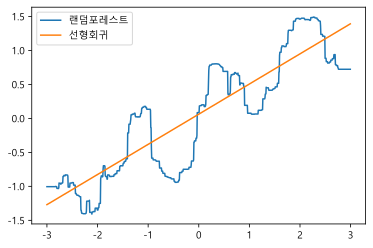

In [11]:
reg = RandomForestRegressor(n_estimators=100, min_samples_leaf=3).fit(X, y)
plt.plot(line, reg.predict(line), label='랜덤포레스트')
reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label='선형회귀')
plt.legend()

In [12]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform').fit(X)
kb.bin_edges_

array([array([-2.9668673 , -2.37804841, -1.78922951, -1.20041062, -0.61159173,
              -0.02277284,  0.56604605,  1.15486494,  1.74368384,  2.33250273,
               2.92132162])                                                   ],
      dtype=object)

In [13]:
X_binned = kb.transform(X)
X_binned.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense').fit(X)
X_binned = kb.transform(X)
line_binned = kb.transform(line)
X_binned

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

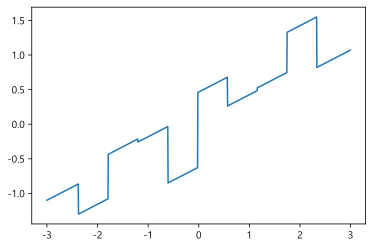

In [15]:
X_combined = np.hstack([X, X_binned])
reg = LinearRegression().fit(X_combined, y)
line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined))

In [16]:
poly = PolynomialFeatures(degree=10, include_bias=False).fit(X)
X_poly = poly.transform(X)
X_poly.shape

(120, 10)

In [17]:
poly.get_feature_names_out()

array(['x0', 'x0^2', 'x0^3', 'x0^4', 'x0^5', 'x0^6', 'x0^7', 'x0^8',
       'x0^9', 'x0^10'], dtype=object)

In [18]:
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston['data'], boston['target'], random_state=0)

c:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [19]:
pipe = make_pipeline(MinMaxScaler(), PolynomialFeatures(degree=2), Ridge()).fit(X_train, y_train)
pipe.score(X_test, y_test)

0.7534782020980574

In [20]:
rnd = np.random.RandomState(0)
X_org = rnd.normal(size=(1000, 3))
w = rnd.normal(size=3)
X = rnd.poisson(10 * np.exp(X_org))
y = np.dot(X_org, w)

<BarContainer object of 141 artists>

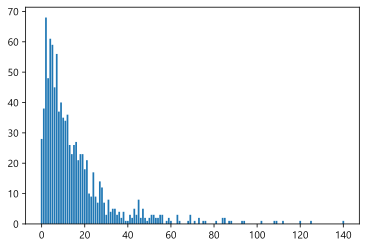

In [21]:
bins = np.bincount(X[:, 0])
plt.bar(range(len(bins)), bins)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [23]:
X_train_log = np.log(X_train + 1)
X_test_log = np.log(X_test + 1)

<BarContainer object of 5 artists>

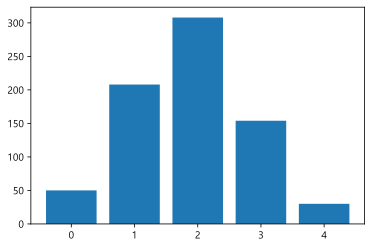

In [24]:
bins = np.bincount(X_train_log[:, 0].astype('int'))
plt.bar(range(len(bins)), bins)

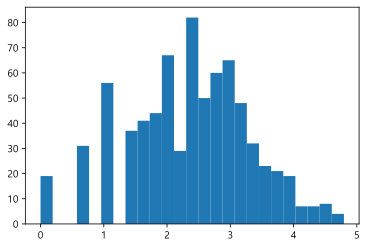

In [25]:
plt.hist(X_train_log[:, 0], bins=25)
plt.show()

In [26]:
cancer = load_breast_cancer()
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer['data']), 50))
X_w_noise = np.hstack([cancer['data'], noise])
X_train, X_test, y_train, y_test = train_test_split(X_w_noise, cancer['target'], random_state=0, test_size=0.5)

In [27]:
select = SelectPercentile(score_func=f_classif, percentile=50).fit(X_train, y_train)
X_train_selected = select.transform(X_train)

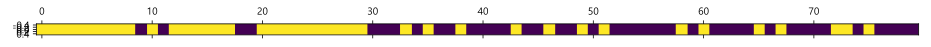

In [28]:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1))

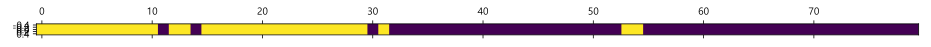

In [29]:
select = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), threshold='1.5 * median').fit(X_train, y_train)
X_train_selected = select.transform(X_train)
mask = select.get_support()
plt.matshow(mask.reshape(1, -1))

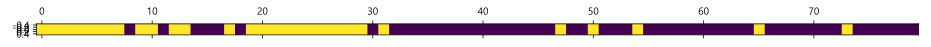

In [30]:
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=30).fit(X_train, y_train)
X_train_selected = select.transform(X_train)
mask = select.get_support()
plt.matshow(mask.reshape(1, -1))

In [31]:
citibike = mglearn.datasets.load_citibike()
citibike.head()

starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64

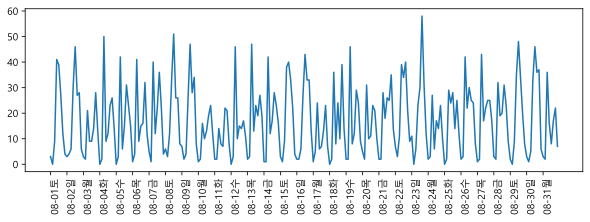

In [32]:
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
week = ['일', '월', '화', '수', '목', '금', '토']
xticks_name = [d + week[int(w)] for w, d in zip(xticks.strftime('%w'), xticks.strftime('%m-%d'))]
plt.figure(figsize=(10, 3))
plt.xticks(xticks, xticks_name, rotation=90, ha='left')
plt.plot(citibike)

In [51]:
y = citibike.values
X = citibike.index.astype('int64').values.reshape(-1, 1) // 10**9
X_hour = citibike.index.hour.values.reshape(-1, 1)
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1), citibike.index.hour.values.reshape(-1, 1)])

In [56]:
n_train = 184
def eval_on_features(features, target, regressor):
    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print(f'테스트 세트 점수 : {regressor.score(X_test, y_test):.2f}')
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    
    plt.figure(figsize=(10, 3))
    plt.xticks(range(0, len(X), 8), xticks_name, rotation=90, ha='left')
    plt.plot(range(n_train), y_train, label='훈련')
    plt.plot(range(n_train), y_pred_train, '--', label='훈련 예측')
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label='테스트')
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label='테스트 예측')
    plt.legend(loc=(1.01, 0))
    plt.xlabel('날짜')
    plt.ylabel('대여 횟수')

테스트 세트 점수 : 0.84


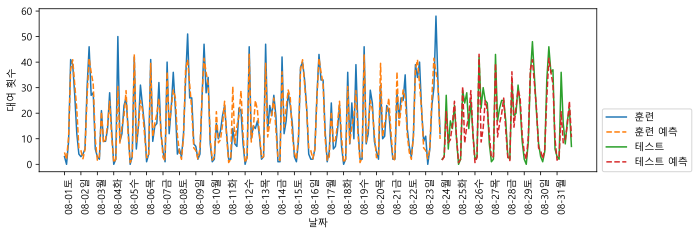

In [60]:
eval_on_features(X_hour_week, y, RandomForestRegressor(n_estimators=100))

In [61]:
X_hour_week_onehot = make_pipeline(OneHotEncoder(sparse=False), PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)).fit_transform(X_hour_week)

테스트 세트 점수 : 0.82


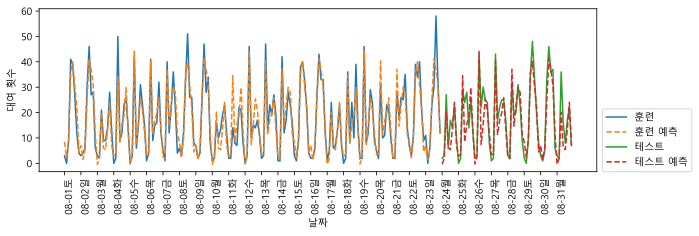

In [62]:
eval_on_features(X_hour_week_onehot, y, LinearRegression())

In [67]:
city_df = citibike.to_frame(name='대여횟수')
city_df.head()

,대여횟수
starttime,
2015-08-01 00:00:00,3
2015-08-01 03:00:00,0
2015-08-01 06:00:00,9
2015-08-01 09:00:00,41
2015-08-01 12:00:00,39


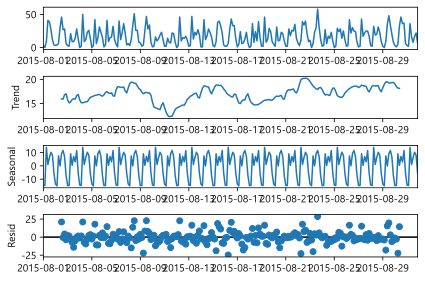

In [70]:
result = seasonal_decompose(city_df, model='additive')
result.plot()
plt.show()

In [81]:
n_train = 184
X_train, X_test = city_df[:n_train], city_df[n_train:]

In [82]:
adfuller(X_train, regression='c')

(-3.498684589660988,
 0.008020940919905966,
 7,
 176,
 {'1%': -3.4680615871598537,
  '5%': -2.8781061899535128,
  '10%': -2.5756015922004134},
 1260.7924126915586)

In [97]:
auto_model = auto_arima(X_train, start_p=1, d=0, start_q=1, max_p=1, max_q=1, 
start_P=1, start_Q=1, max_P=1, max_Q=1, m=8, seasonal=True, information_criterion='aic')
auto_model

ARIMA(order=(0, 0, 1), scoring_args={}, seasonal_order=(1, 0, 0, 8),
      suppress_warnings=True)

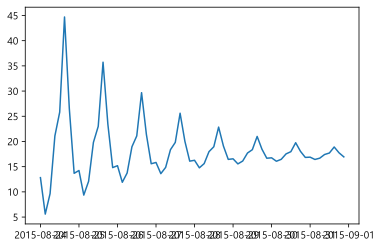

In [98]:
plt.plot(auto_model.predict(n_periods=len(X_test)))